In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.special import gamma

from scipy.io import savemat

from lmfit import Minimizer, Parameters, create_params, report_fit, Model

import tensorflow as tf
print(tf. __version__)

2.10.0


## Load data

In [2]:
W_list = [1,10,20,30,40]

In [3]:
import os
## load D22 data
data_path = './20230804/'
data_list = []
for W in W_list:
    filename = '11.5_{}.dat'.format(W)
    data = np.genfromtxt(data_path + filename, skip_header=39, delimiter='\t')
    data_list.append(data)
    # Q = data[:,0]
    # IQ = data[:,1]
    # IQ_er = data[:,2]
    # sigma_Q = data[:,3]
    

## Plot data

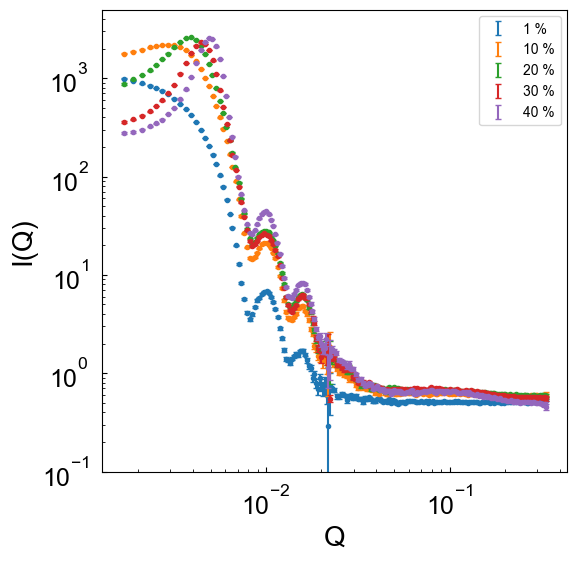

In [4]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

colors = ['C0','C1','C2','C3','C4']
for i, W in enumerate(W_list):
    dataname = '{} %'.format(W)
    data = data_list[i]
    Q = data[:,0]
    IQ = data[:,1]
    IQ_er = data[:,2]
    sigma_Q = data[:,3]
    ax.plot(Q,IQ,'.', color = colors[i])
    ax.errorbar(Q,IQ,IQ_er,linestyle='',label=dataname, color = colors[i] ,capsize=2)

ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_ylim([0.1,5000])
ax.set_xlabel('Q',fontsize=20)
ax.set_ylabel('I(Q)',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.legend()
plt.show()

## Define function

In [5]:
## fit desmeared D22 dilute data for form factor

# fit P(Q)
def hardsphere(q,sigma=1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2
    return P

def fuzzysphere(q,sigma=1,sigma_f=0.1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2*np.exp(-(sigma_f*sigma*q)**2/2)
    return P

def log_normal_pdf(mu,sigma,x):
    return np.exp(-(np.log(x)-mu)**2/2/sigma**2)/x/sigma

def P_HS_eff(q,sigma=1,d_sigma=0.05):
    n_sample = 301
    sigma_list = (1+np.linspace(-9,9,n_sample)*d_sigma)*sigma
    # p_sigma = np.exp(np.linspace(-3,3,n_sample)**2/2)*(sigma_list)**6
    p_sigma = log_normal_pdf(0,d_sigma,sigma_list/sigma)*(sigma_list)**6
    # var = d_sigma**2
    # k = 1/var
    # x = (1+np.linspace(-3,3,n_sample)*d_sigma)
    # p_sigma = k**k*x**(k-1)*np.exp(-k*x)/gamma(k)

    P_eff = np.zeros_like(q)

    for i in range(n_sample):
        P_i = hardsphere(q,sigma_list[i])*p_sigma[i]
        P_eff = P_eff + P_i

    P_eff = P_eff/np.sum(p_sigma)

    return P_eff

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ_resoln = IQ_th*w_gauss
        
        IQ.append(np.trapz(IQ_resoln,Q_fine)/np.trapz(w_gauss,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out # sampled on Q

def I_P(Q, dQ, sigma, A, I_inc, d_sigma):
    # desmeared
    P = P_HS_eff(Q,sigma=sigma,d_sigma=d_sigma)
    Q_fine = Q
    P_res = IQ_resoln(Q,Q_fine,P,dQ)
    f_interp = interp.interp1d(Q_fine,P_res,fill_value='extrapolate')
    P = f_interp(Q)

    return A*P + I_inc    

def I_P_d(Q, sigma, A, I_inc, d_sigma):
    # desmeared
    P = P_HS_eff(Q,sigma=sigma,d_sigma=d_sigma)
    # Q_fine = Q
    # P_res = IQ_resoln(Q_p,Q_fine,P,dQ_p*1.0)
    # f_interp = interp.interp1d(Q_fine,P_res,fill_value='extrapolate')
    # P = f_interp(Q)

    return A*P + I_inc    

## Fit form factor

In [6]:
# 1%
data = data_list[0]
Q = data[:,0]
IQ = data[:,1]
IQ_er = data[:,2]
sigma_Q = data[:,3]

# remove extreme values
index_extreme = IQ<0.4
Q = np.delete(Q,index_extreme)
IQ = np.delete(IQ,index_extreme)
IQ_er = np.delete(IQ_er,index_extreme)
sigma_Q = np.delete(sigma_Q,index_extreme)

# initialize parameters
params = Parameters()
params.add('sigma', value=1200, min=1100, max=1300)
params.add('A', value=1e3, min=5e2, max=1.5e3)
params.add('I_inc', value=0.8, min=0.5, max=1)
params.add('d_sigma', value=0.01, min=0.005, max=0.15)

index_Q = (Q>1e-3)*(Q<5e-1)
# loss function for fitting form factor
def lambda_P(params, Q, dQ, IQ_exp, index_Q):
    v = params.valuesdict()
    return (np.log(I_P(Q, dQ, v['sigma'], v['A'], v['I_inc'], v['d_sigma'])) 
          - np.log(IQ_exp))[index_Q]

# do fit, here with the default leastsq algorithm
minner = Minimizer(lambda_P, params, fcn_args=(Q, sigma_Q, IQ, index_Q))
result_P = minner.minimize(method='leastsq')

# fitted curve
v = result_P.params.valuesdict()
IQ_fit = I_P(Q, sigma_Q, v['sigma'], v['A'], v['I_inc'], v['d_sigma'])

# write error report
report_fit(result_P)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 192
    # variables        = 4
    chi-square         = 0.68267032
    reduced chi-square = 0.00363123
    Akaike info crit   = -1074.73381
    Bayesian info crit = -1061.70383
[[Variables]]
    sigma:    1149.11068 +/- 2.25725391 (0.20%) (init = 1200)
    A:        1197.03484 +/- 13.3791966 (1.12%) (init = 1000)
    I_inc:    0.50802537 +/- 0.00274907 (0.54%) (init = 0.8)
    d_sigma:  0.05681853 +/- 0.00239859 (4.22%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, A)       = +0.5732
    C(sigma, d_sigma) = -0.2904
    C(A, I_inc)       = -0.1008


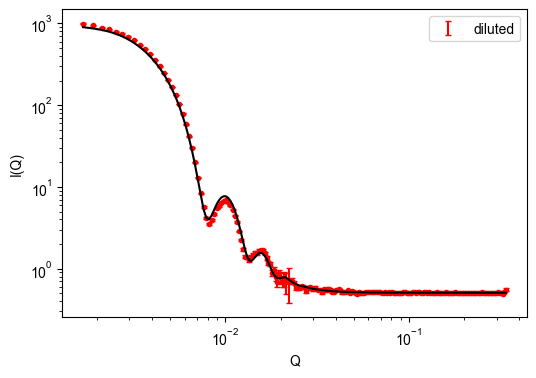

In [7]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q,IQ,'.r')
ax.errorbar(Q,IQ,IQ_er,linestyle='',label='diluted',color='r',capsize=2)
# ax.plot(Q_p,IQ_data_p,'.m',label='diluted')
ax.plot(Q[index_Q],IQ_fit,'-k',zorder=3)
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 159
    # variables        = 2
    chi-square         = 0.80756728
    reduced chi-square = 0.00514374
    Akaike info crit   = -835.938665
    Bayesian info crit = -829.800856
[[Variables]]
    A:      4156.40076 +/- 62.1298945 (1.49%) (init = 10000)
    I_inc:  0.60676630 +/- 0.00411183 (0.68%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, I_inc) = -0.1834


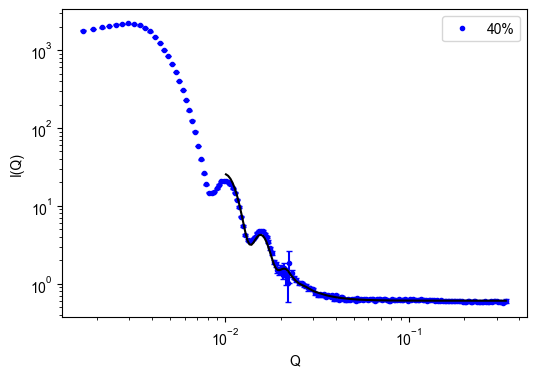

In [8]:
# 10%
data = data_list[1]
Q = data[:,0]
IQ = data[:,1]
IQ_er = data[:,2]
sigma_Q = data[:,3]

# loss function for fitting form factor
def lambda_I(params, Q, dQ, IQ_exp, index_Q):
    v = params.valuesdict()
    return (np.log(I_P(Q, dQ, sigma_P, v['A'], v['I_inc'], d_sigma_P)) 
          - np.log(IQ_exp))[index_Q]

sigma_P = result_P.params.valuesdict()['sigma']
d_sigma_P = result_P.params.valuesdict()['d_sigma']

params = Parameters()
params.add('A', value=1e4, min=2e2, max=2e4)
params.add('I_inc', value=0.5, min=0.1, max=2)

index_Q = (Q>1e-2)*(Q<5e-1)

# do fit, here with the default leastsq algorithm
minner = Minimizer(lambda_I, params, fcn_args=(Q, sigma_Q, IQ, index_Q))
result_I = minner.minimize()

# fitted curve
v = result_I.params.valuesdict()
IQ_fit = I_P(Q, sigma_Q, sigma_P, v['A'], v['I_inc'], d_sigma_P)

# write error report
report_fit(result_I)

# plot fit curve
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q,IQ,'.b',label='{}%'.format(W))
ax.errorbar(Q,IQ,IQ_er,linestyle='',color='b',capsize=2)
ax.plot(Q[index_Q],IQ_fit[index_Q],'-k')
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

C:\Users\wagen\AppData\Local\Temp\ipykernel_130460\1876625000.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0,0.04])


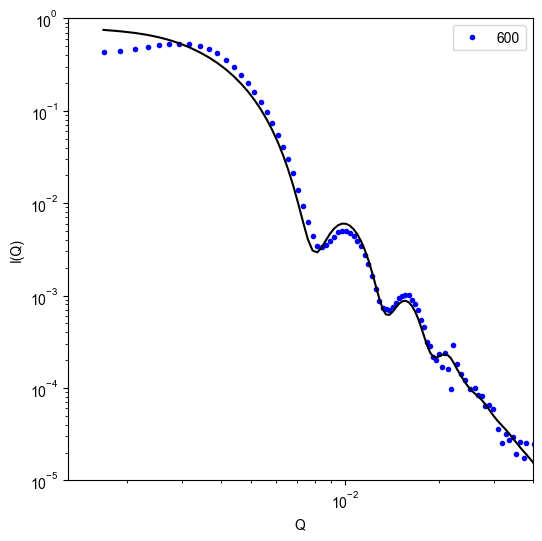

In [9]:
fp_opt_P = result_P.params.valuesdict()
fp_opt_I = result_I.params.valuesdict()

IQ_0 = (IQ-fp_opt_I['I_inc'])/fp_opt_I['A']

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(Q,IQ_0,'.b',label='600')
ax.plot(Q, I_P(Q, sigma_Q, fp_opt_P['sigma'],1,0,fp_opt_P['d_sigma']),'-k')
# ax.errorbar(Q_cat,IQ_cat,IQ_er_cat,linestyle='',color='k',capsize=2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0,0.04])
ax.set_ylim([1e-5,1])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

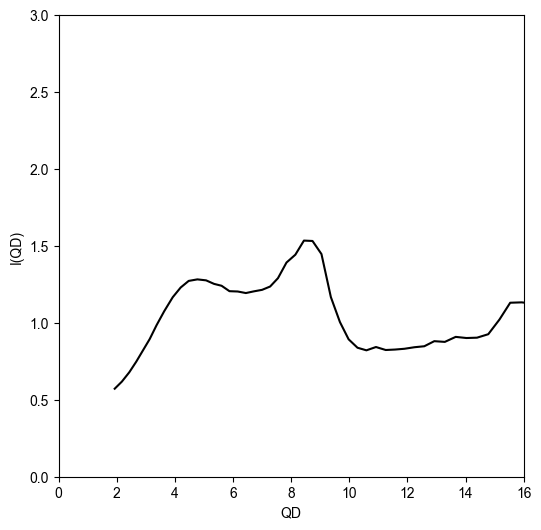

In [10]:
fp_opt_P = result_P.params.valuesdict()
fp_opt_I = result_I.params.valuesdict()

IQ_0 = (IQ-fp_opt_I['I_inc'])/fp_opt_I['A']

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
# ax.plot(Q,IQ_0,'.b',label='600')
ax.plot(Q*fp_opt_P['sigma'], 
        IQ_0/I_P(Q, sigma_Q, fp_opt_P['sigma'],1,0,fp_opt_P['d_sigma']),'-k')
# ax.errorbar(Q_cat,IQ_cat,IQ_er_cat,linestyle='',color='k',capsize=2)

# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([0,16])
ax.set_ylim([0,3])
ax.set_xlabel('QD')
ax.set_ylabel('I(QD)')
plt.show()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 159
    # variables        = 2
    chi-square         = 2.35547395
    reduced chi-square = 0.01500302
    Akaike info crit   = -665.733796
    Bayesian info crit = -659.595988
[[Variables]]
    A:      7664.72477 +/- 173.421808 (2.26%) (init = 10000)
    I_inc:  0.58084422 +/- 0.00689979 (1.19%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, I_inc) = -0.1688


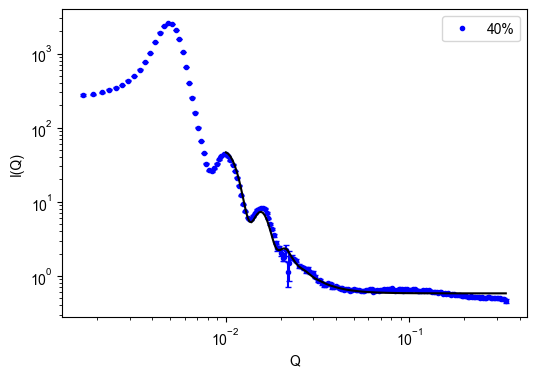

In [11]:
# 40%
data = data_list[4]
Q = data[:,0]
IQ = data[:,1]
IQ_er = data[:,2]
sigma_Q = data[:,3]

# loss function for fitting form factor
def lambda_I(params, Q, dQ, IQ_exp, index_Q):
    v = params.valuesdict()
    return (np.log(I_P(Q, dQ, sigma_P, v['A'], v['I_inc'], d_sigma_P)) 
          - np.log(IQ_exp))[index_Q]

sigma_P = result_P.params.valuesdict()['sigma']
d_sigma_P = result_P.params.valuesdict()['d_sigma']

params = Parameters()
params.add('A', value=1e4, min=2e2, max=2e4)
params.add('I_inc', value=0.5, min=0.1, max=2)

index_Q = (Q>1e-2)*(Q<5e-1)

# do fit, here with the default leastsq algorithm
minner = Minimizer(lambda_I, params, fcn_args=(Q, sigma_Q, IQ, index_Q))
result_I = minner.minimize()

# fitted curve
v = result_I.params.valuesdict()
IQ_fit = I_P(Q, sigma_Q, sigma_P, v['A'], v['I_inc'], d_sigma_P)

# write error report
report_fit(result_I)

# plot fit curve
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(Q,IQ,'.b',label='{}%'.format(W))
ax.errorbar(Q,IQ,IQ_er,linestyle='',color='b',capsize=2)
ax.plot(Q[index_Q],IQ_fit[index_Q],'-k')
# ax.plot(Q_1,IQ_data_1/I_P(fp_opt_P[0],fp_opt_P[1],fp_opt_P[2]))
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,0.2])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

C:\Users\wagen\AppData\Local\Temp\ipykernel_130460\1876625000.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim([0,0.04])


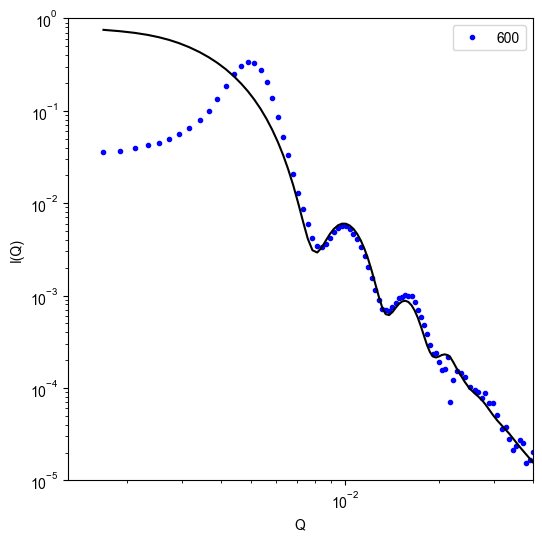

In [12]:
fp_opt_P = result_P.params.valuesdict()
fp_opt_I = result_I.params.valuesdict()

IQ_0 = (IQ-fp_opt_I['I_inc'])/fp_opt_I['A']

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.plot(Q,IQ_0,'.b',label='600')
ax.plot(Q, I_P(Q, sigma_Q, fp_opt_P['sigma'],1,0,fp_opt_P['d_sigma']),'-k')
# ax.errorbar(Q_cat,IQ_cat,IQ_er_cat,linestyle='',color='k',capsize=2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0,0.04])
ax.set_ylim([1e-5,1])
ax.set_xlabel('Q')
ax.set_ylabel('I(Q)')
ax.legend()
plt.show()

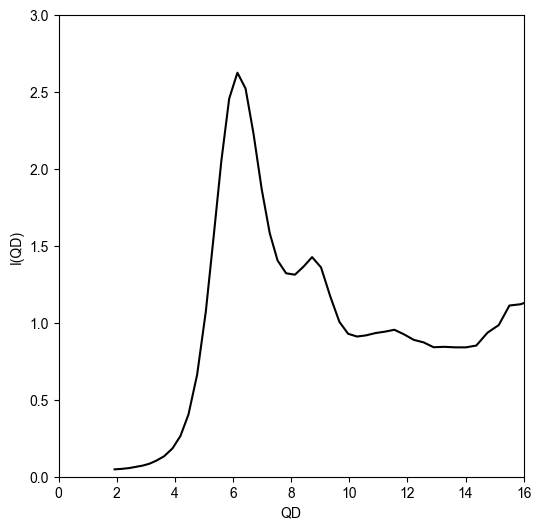

In [13]:
fp_opt_P = result_P.params.valuesdict()
fp_opt_I = result_I.params.valuesdict()

IQ_0 = (IQ-fp_opt_I['I_inc'])/fp_opt_I['A']

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
# ax.plot(Q,IQ_0,'.b',label='600')
ax.plot(Q*fp_opt_P['sigma'], 
        IQ_0/I_P(Q, sigma_Q, fp_opt_P['sigma'],1,0,fp_opt_P['d_sigma']),'-k')
# ax.errorbar(Q_cat,IQ_cat,IQ_er_cat,linestyle='',color='k',capsize=2)

# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([0,16])
ax.set_ylim([0,3])
ax.set_xlabel('QD')
ax.set_ylabel('I(QD)')
plt.show()